This gives an example of the use of the Markov Switching Model that I wrote for the [Statsmodels](https://github.com/statsmodels/statsmodels) Python package, to replicate the treatment of Kim, Nelson, and Startz (1998) as given in Kim and Nelson (1999). This model demonstrates estimation with regime heteroskedasticity (switching of variances) and fixed means (all at zero).

This is tested against Kim and Nelson's (1999) code (STCK_V3.OPT), which can be found at [http://econ.korea.ac.kr/~cjkim/SSMARKOV.htm](http://econ.korea.ac.kr/~cjkim/SSMARKOV.htm). It also corresponds to the examples of Markov-switching models from E-views 8, which can be found at [http://www.eviews.com/EViews8/ev8ecswitch_n.html#RegHet](http://www.eviews.com/EViews8/ev8ecswitch_n.html#RegHet).

<!-- TEASER_END -->

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.mar_model import MAR

In [2]:
# Model Setup
order = 0
nstates = 3

switch_ar = False
switch_var = True
switch_mean = [0,0,0]

In [3]:
# Equal-Weighted Excess Returns
f = open('data/ew_excs.prn')
data = pd.DataFrame(
    [float(line.strip()) for line in f.readlines()[:-3]],
    # Not positive these are the right dates...
    index=pd.date_range('1926-01-01', '1995-10-01', freq='MS'),
    columns=['ewer']
)
data = data[0:732]
data['dmewer'] = data['ewer'] - data['ewer'].mean()

In [4]:
mod = MAR(data.dmewer, 0, nstates,
          switch_ar=switch_ar, switch_var=switch_var, switch_mean=switch_mean)
params = np.array([
    16.399767, 12.791361, 0.522758, 4.417225, -5.845336, -3.028234,
    6.704260/2,  5.520378/2,  3.473059/2
])

In [5]:
# Filter the data
(
    marginal_densities, filtered_joint_probabilities,
    filtered_joint_probabilities_t1
) = mod.filter(params);

transitions = mod.separate_params(params)[0]

# Smooth the data
filtered_marginal_probabilities = mod.marginalize_probabilities(filtered_joint_probabilities[1:])
smoothed_marginal_probabilities = mod.smooth(filtered_joint_probabilities, filtered_joint_probabilities_t1, transitions)

# Save the data
data['smoothed_low'] = np.r_[
    [np.NaN]*order,
    smoothed_marginal_probabilities[:,0]
]
data['smoothed_medium'] = np.r_[
    [np.NaN]*order,
    smoothed_marginal_probabilities[:,1]
]
data['smoothed_high'] = np.r_[
    [np.NaN]*order,
    smoothed_marginal_probabilities[:,2]
]

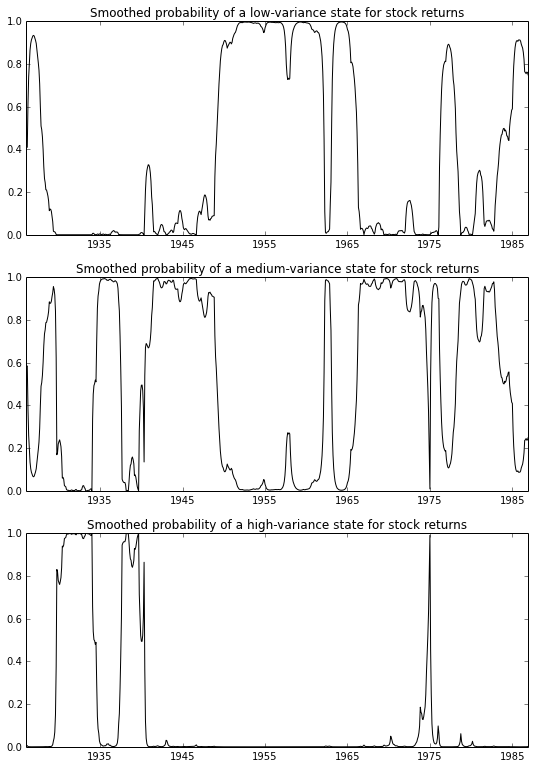

In [6]:
import matplotlib.pyplot as plt
from matplotlib import dates
fig = plt.figure(figsize=(9,13))

ax = fig.add_subplot(311)
ax.plot(data.index, data.smoothed_low, 'k')
ax.set(
    xlim=('1926-01-01', '1986-12-01'),
    ylim=(0,1),
    title='Smoothed probability of a low-variance state for stock returns'
);
ax = fig.add_subplot(312)
ax.plot(data.index, data.smoothed_medium, 'k')
ax.set(
    xlim=('1926-01-01', '1986-12-01'),
    ylim=(0,1),
    title='Smoothed probability of a medium-variance state for stock returns'
);
ax = fig.add_subplot(313)
ax.plot(data.index, data.smoothed_high, 'k')
ax.set(
    xlim=('1926-01-01', '1986-12-01'),
    ylim=(0,1),
    title='Smoothed probability of a high-variance state for stock returns'
);